In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
model = models.resnet50(pretrained=True)

/home/ahmad10raza/anaconda3/envs/aiml-test/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmad10raza/anaconda3/envs/aiml-test/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ahmad10raza/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Step 3: Freeze Early Layers (Optional, Feature Extraction Phase)


In [5]:
for param in model.parameters():
    param.requires_grad=False

### Step 4: Modify the Final Fully Connected Layer


In [6]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 11)

### Step 5: Define Transforms (Preprocessing)

In [7]:
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    ),
])

### Step 6: Load Your Dataset

In [13]:
train_dataset = datasets.ImageFolder('Data/train', transform=transforms)
val_dataset = datasets.ImageFolder('Data/val', transform=transforms)

train_load = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Step 7: Set Criterion and Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [18]:
devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(devices)

num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    
    for inputs, lables in train_load:
        inputs, lables = inputs.to(devices), lables.to(devices)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,lables)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

Epoch [1/25] Loss: 0.3798
Epoch [2/25] Loss: 0.1483
Epoch [3/25] Loss: 0.2411
Epoch [4/25] Loss: 0.1263
Epoch [5/25] Loss: 0.1520
Epoch [6/25] Loss: 0.1134
Epoch [7/25] Loss: 0.2207
Epoch [8/25] Loss: 0.1328
Epoch [9/25] Loss: 0.0987
Epoch [10/25] Loss: 0.0649
Epoch [11/25] Loss: 0.2795
Epoch [12/25] Loss: 0.1012
Epoch [13/25] Loss: 0.2314
Epoch [14/25] Loss: 0.2987
Epoch [15/25] Loss: 0.1293
Epoch [16/25] Loss: 0.0118
Epoch [17/25] Loss: 0.0498
Epoch [18/25] Loss: 0.1429
Epoch [19/25] Loss: 0.1452
Epoch [20/25] Loss: 0.1345
Epoch [21/25] Loss: 0.0782
Epoch [22/25] Loss: 0.3048
Epoch [23/25] Loss: 0.2004
Epoch [24/25] Loss: 0.0438
Epoch [25/25] Loss: 0.1578


#### Step 9: Unfreeze Some Earlier Layers for Fine-Tuning

In [19]:
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

### Step 10: Use a Lower Learning Rate for Fine-Tuning

In [20]:
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4
)


### Step 11: Fine-Tune Full Model

In [21]:
num_epochs = 10  # fine-tuning epochs

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_load:
        inputs, labels = inputs.to(devices), labels.to(devices)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')


Epoch [1/10] Loss: 0.2641
Epoch [2/10] Loss: 0.1761
Epoch [3/10] Loss: 0.0774
Epoch [4/10] Loss: 0.1687
Epoch [5/10] Loss: 0.0304
Epoch [6/10] Loss: 0.1047
Epoch [7/10] Loss: 0.1587
Epoch [8/10] Loss: 0.1355
Epoch [9/10] Loss: 0.0286
Epoch [10/10] Loss: 0.1321


 🚀 When you're fine-tuning **ResNet-50**, making the process **faster and more efficient** is key to saving both time and resources. Here are **best practices** to help speed up the fine-tuning process:



# 🛠 Best Practices to Fine-Tune Faster in ResNet-50

### 1. **Use Pretrained Weights (Always!)**
Always start with **pre-trained weights** from ImageNet, as they already contain useful knowledge that will speed up convergence. **This is the essence of transfer learning**.

- **Don't train from scratch**, unless you absolutely need to.
- In PyTorch, use `resnet50(pretrained=True)` to load pre-trained weights.



### 2. **Start with Smaller Learning Rates**
When fine-tuning, using a **smaller learning rate** initially ensures that you don’t disrupt the learned features in the pre-trained model. 

- Start with a **low learning rate** like `1e-4` or `1e-5` for the first few epochs, then increase gradually if needed.
- Use **learning rate scheduling** to adjust dynamically during training (e.g., **Cosine Annealing**, **One-Cycle Policy**).



### 3. **Use Gradual Unfreezing (Layer-wise Training)**
Instead of unfreezing all layers at once, **unfreeze layers gradually** to avoid disturbing the pre-trained features.

- **Start by freezing most layers**, then gradually **unfreeze the deeper layers** for fine-tuning.
- Initially, fine-tune only the **last few layers** (like the fully connected layers) of ResNet-50. Then, progressively unfreeze more layers.
- This allows the network to adapt better without overfitting early on.



### 4. **Use Data Augmentation (Boosts Generalization and Speed)**
Use **aggressive data augmentation** during training. This not only improves generalization but can **speed up convergence** because it helps the model learn more varied representations from the same data.

Common augmentations:
- **Random Horizontal Flip**
- **Random Rotation**
- **Random Cropping**
- **Color Jitter (Brightness, Contrast, Saturation)**

```python
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
```



### 5. **Use Mixed Precision Training**
Mixed precision allows you to use **half-precision floats (FP16)** instead of single-precision (FP32), resulting in **faster training and lower memory usage** without sacrificing accuracy.

- PyTorch supports this with **automatic mixed precision (AMP)**.
- Use the `torch.cuda.amp` package to enable AMP in your training loop.

Example:
```python
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Inside training loop
for inputs, labels in dataloader:
    optimizer.zero_grad()
    
    with autocast():  # Use mixed precision
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
```



### 6. **Use Faster Optimizers**
Switch to **faster optimizers** like **AdamW** instead of regular **SGD**. AdamW adapts learning rates for each parameter, which can lead to **faster convergence**.

- **AdamW** (instead of Adam or SGD) improves training stability and speeds up convergence.
- Example:
  ```python
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
  ```



### 7. **Utilize Transfer Learning on Smaller Subsets First**
Start by fine-tuning on a **small subset** of your training data. This helps you:
- **Test your training pipeline** quickly.
- Adjust hyperparameters without waiting for long epochs.
- Identify issues and make sure everything is set up correctly before scaling up.



### 8. **Use Multi-GPU (If Available)**
If you have access to **multiple GPUs**, you can use **Data Parallelism** to speed up training by distributing the work across multiple GPUs.

- In PyTorch, you can easily use `nn.DataParallel(model)` to parallelize the model across multiple GPUs.

```python
model = nn.DataParallel(model)
model = model.cuda()
```



### 9. **Early Stopping**
Use **early stopping** to halt training when the model stops improving on the validation set. This saves time and prevents overfitting.

- Track the **validation loss** and stop if it doesn't improve for a specified number of epochs.

Example (simplified):
```python
# Define early stopping mechanism based on validation loss
patience = 5  # how many epochs to wait before stopping
counter = 0
best_loss = float('inf')

for epoch in range(num_epochs):
    # Training loop
    train_loss = train_epoch(model, optimizer, data_loader)

    # Validation loop
    val_loss = validate(model, val_loader)

    # Early stopping condition
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping...")
        break
```



### 10. **Reduce the Batch Size (If Memory Allows)**
- If your GPU memory allows, reducing the **batch size** can help reduce training time per epoch.
- This also allows more frequent updates to weights, speeding up convergence.

However, **beware** of going too low on batch size since it might hurt training stability, so **find a balance**.



### 11. **Use Learning Rate Finder**
Before you start training, try using a **learning rate finder** to find the best starting learning rate.

- Libraries like **fastai** offer a built-in learning rate finder that helps you identify the optimal learning rate quickly.



# 🚀 Summary of Best Practices

1. **Pre-trained weights** for faster convergence.
2. Start with **smaller learning rates**.
3. Use **gradual unfreezing** (start fine-tuning with only top layers).
4. Apply **aggressive data augmentation**.
5. Enable **mixed precision training**.
6. Use **AdamW optimizer**.
7. Fine-tune on **smaller subsets** first.
8. Use **multi-GPU** (if available).
9. Implement **early stopping**.
10. Fine-tune with **optimal batch size**.
11. Use **learning rate finder** to choose the best LR.


## 1. Evaluate the Model

### 1.1 Calculate Validation Accuracy
You should check how well your model is generalizing to the unseen data in the validation set. Here's how to do it:

In [23]:
# Evaluation loop to calculate accuracy
model.eval()  # Switch model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in val_loader:  # val_loader is your validation data
        images, labels = inputs.to(devices), labels.to(devices)
        outputs = model(images)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = (correct / total) * 100
print(f'Validation Accuracy: {accuracy:.2f}%')


RuntimeError: The size of tensor a (28) must match the size of tensor b (32) at non-singleton dimension 0

In [25]:
# Evaluation loop to calculate accuracy
model.eval()  # Switch model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in val_loader:  # val_loader is your validation data
        # Move data to the correct device
        images, labels = images.to(devices), labels.to(devices)

        outputs = model(images)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get predicted class

        # Make sure to handle last batch size mismatch
        batch_size = labels.size(0)  # Size of the current batch (can be smaller for the last batch)
        total += batch_size
        correct += (predicted == labels).sum().item()

accuracy = (correct / total) * 100
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Accuracy: 99.82%


## 1.2 Plot Loss and Accuracy Graphs
Visualize the training and validation loss/accuracy over epochs to identify overfitting and underfitting

In [ ]:
import matplotlib.pyplot as plt

# Assuming you've saved loss values for each epoch in lists `train_loss` and `val_loss`
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


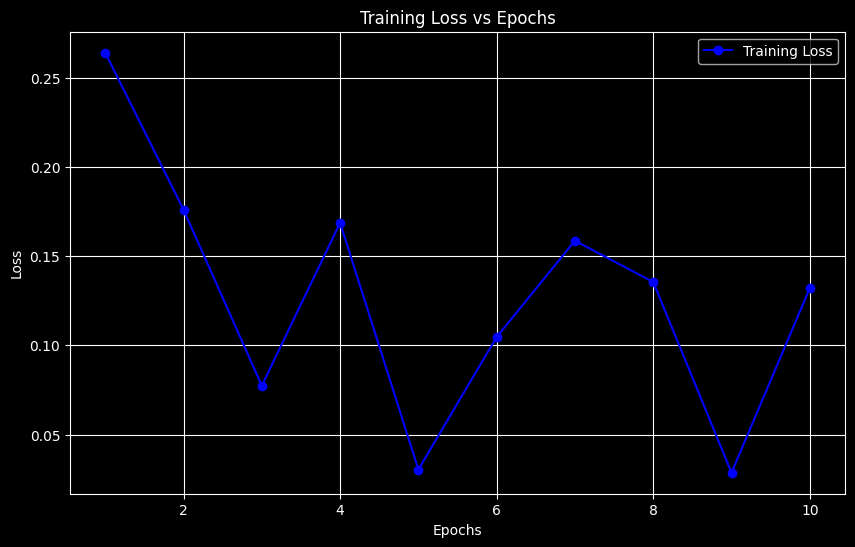

In [26]:
import matplotlib.pyplot as plt

# List of epoch losses (from your output)
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
losses = [0.2641, 0.1761, 0.0774, 0.1687, 0.0304, 0.1047, 0.1587, 0.1355, 0.0286, 0.1321]

plt.style.use('dark_background')

# Plotting the Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', color='b', label='Training Loss')

# Adding title and labels
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Displaying legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


## 2. Save the Fine-Tuned Model

In [27]:
# Save the model
torch.save(model.state_dict(), 'resnet50_finetuned.pth')

In [ ]:
# Load the saved model
model.load_state_dict(torch.load('resnet50_finetuned.pth'))

## 3. Make Predictions

In [ ]:
# Set model to evaluation mode
model.eval()

# Example for predicting a new image
from PIL import Image
img = Image.open('Data/val/n01440764/n01440764_36.JPEG')
img = transforms(img).unsqueeze(0)  # Apply the same transformations used for training



with torch.no_grad():
   
    output = model(img)
    _, predicted = torch.max(output, 1)
    print(f'Predicted Class: {predicted.item()}')


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

### 4.1 Try Learning Rate Scheduling
Since you observed some fluctuations, adjusting the learning rate dynamically during training can help stabilize learning. Common strategies include Cosine Annealing or One-Cycle Learning Rate.

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # T_max = total number of epochs

for epoch in range(10):
    train_epoch()  # your training loop
    scheduler.step()  # Update learning rate at the end of each epoch


### 4.2 Implement Early Stopping
Monitor validation loss during training and stop training early if it doesn’t improve for a set number of epochs. This prevents overfitting.

In [ ]:
patience = 5  # Stop after 5 epochs without improvement
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(10):
    train_epoch()  # Your training loop
    val_loss = validate_model()  # Compute validation loss
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


## 5. Deploy the Model
Once you're satisfied with the model’s performance, it’s time to deploy it to serve predictions in a real-world application.



### 5.1 Convert to TorchScript (for production)
TorchScript allows you to run the model in C++ environments, on mobile, or in any framework that can load the model.

In [ ]:
# Convert to TorchScript
model.eval()  # Make sure to set the model to evaluation mode
scripted_model = torch.jit.script(model)  # Or `torch.jit.trace(model, example_input)`

# Save the TorchScript model
scripted_model.save('resnet50_finetuned.pt')


### 5.2 Serve the Model with a Web Framework (like Flask or FastAPI)
To create a web service around your model, you can use frameworks like Flask or FastAPI.



In [ ]:
from flask import Flask, request, jsonify
import torch
from PIL import Image
import io

app = Flask(__name__)

# Load the model
model = resnet50(pretrained=False)
model.load_state_dict(torch.load('resnet50_finetuned.pth'))
model.eval()

@app.route('/predict', methods=['POST'])
def predict():
    # Read image from POST request
    img_data = request.files['image'].read()
    img = Image.open(io.BytesIO(img_data)).convert('RGB')

    # Apply same transformations
    img = transform(img).unsqueeze(0)

    # Get prediction
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)

    return jsonify({'class': predicted.item()})

if __name__ == '__main__':
    app.run(debug=True)
